In [1]:
!wget https://www.dropbox.com/s/nilt43hyl1dx82k/dataset.zip?dl=0

--2023-07-31 10:57:38--  https://www.dropbox.com/s/nilt43hyl1dx82k/dataset.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/nilt43hyl1dx82k/dataset.zip [following]
--2023-07-31 10:57:39--  https://www.dropbox.com/s/raw/nilt43hyl1dx82k/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8ffd6aa53bfefd4813c85854b2.dl.dropboxusercontent.com/cd/0/inline/CA74D7ibIeRgY-JS1JesN0ruZO_Gyoz4RGoYVtqSskmjGU19dfJ00vhuENDhQuoIZ7zDWf2zhbqLInnSai_uR-r6trMoePq0YTVrFtq1lDBNaZufvbImPSTOW15YyArfG4Hi3_aUg2RHhLxRnmFfE4ap/file# [following]
--2023-07-31 10:57:39--  https://uc8ffd6aa53bfefd4813c85854b2.dl.dropboxusercontent.com/cd/0/inline/CA74D7ibIeRgY-JS1JesN0ruZO_Gyoz4RGoYVtqSskmjGU19dfJ00vhuENDhQuoIZ7zDWf2zhbqLInnSai_uR-r6trMoePq0YTVr

In [2]:
!unzip dataset.zip?dl=0

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.layers import Flatten,Dense,GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.losses import categorical_crossentropy

# Training data

In [5]:
train_data_gen=ImageDataGenerator(rotation_range=40,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.2,
                              zoom_range=0.2,
                              rescale=1./255,
                              horizontal_flip=True,
                              fill_mode='nearest'
                              )
train_data=train_data_gen.flow_from_directory(directory='/content/train',
                                              target_size=(224,224),
                                              batch_size=32
                                              )
train_data.class_indices

Found 28709 images belonging to 7 classes.


{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [6]:
train_data.image_shape

(224, 224, 3)

# Validation Data

In [7]:
val_data_gen=ImageDataGenerator(rescale=1./255)

val_data=val_data_gen.flow_from_directory(directory='/content/test',
                                          target_size=(224,224),
                                          batch_size=32)

Found 7178 images belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


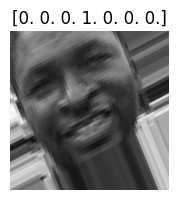

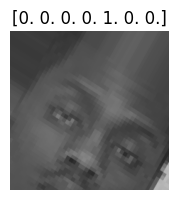

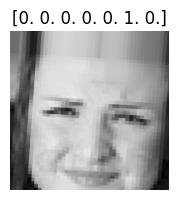

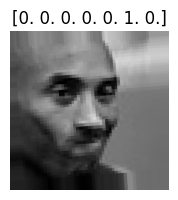

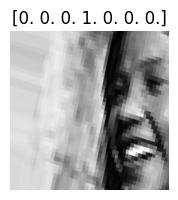

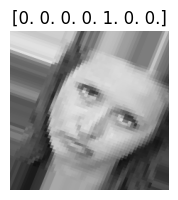

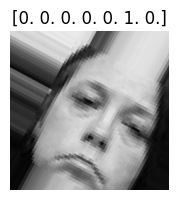

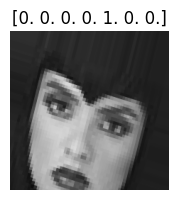

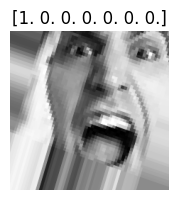

In [8]:
image_vectors, labels=train_data.next()
lis=list(range(1,10))
for i,img, label in zip(lis,image_vectors,labels):
  plt.figure(figsize=(7,7))
  ax=plt.subplot(3,3,i)
  plt.imshow(img)
  plt.title(label)
  plt.axis("off")

# Build Model

In [27]:
base_model = MobileNet( input_shape=(224,224,3), include_top= False ,weights='imagenet')

for layer in base_model.layers:
  layer.trainable = False


x = GlobalAveragePooling2D()(base_model.output)
x = Dense(640, activation='relu')(x)
x= Dense(320, activation='relu')(x)
x = Dense(units=7 , activation='softmax' )(x)

# creating our model.
model = Model(base_model.input, x)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [28]:
from keras.optimizers import Adam
model.compile(optimizer="adam", loss=categorical_crossentropy, metrics=["accuracy"])

In [29]:
early_stopping=EarlyStopping(monitor="val_accuracy",verbose=1,min_delta=0.01, mode="auto", patience=7)
model_checkpoint=ModelCheckpoint(filepath="best_model.h5", monitor="val_accuracy",verbose=1,save_best_only=True,mode="auto")
callbacks=[early_stopping,model_checkpoint]
values=model.fit_generator(train_data,
                           steps_per_epoch=10,
                           epochs=30,
                           validation_data=val_data,
                           validation_steps=8,
                           callbacks=callbacks)

<ipython-input-29-e36dd4d9001b>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  values=model.fit_generator(train_data,


Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 2.2467 - accuracy: 0.1813
Epoch 1: val_accuracy improved from -inf to 0.21094, saving model to best_model.h5
10/10 [==============================] - 8s 489ms/step - loss: 2.2467 - accuracy: 0.1813 - val_loss: 2.1994 - val_accuracy: 0.2109
Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 1.9249 - accuracy: 0.1969
Epoch 2: val_accuracy improved from 0.21094 to 0.27734, saving model to best_model.h5
10/10 [==============================] - 4s 439ms/step - loss: 1.9249 - accuracy: 0.1969 - val_loss: 1.8034 - val_accuracy: 0.2773
Epoch 3/30
10/10 [==============================] - ETA: 0s - loss: 1.7826 - accuracy: 0.2688
Epoch 3: val_accuracy did not improve from 0.27734
10/10 [==============================] - 4s 421ms/step - loss: 1.7826 - accuracy: 0.2688 - val_loss: 1.7704 - val_accuracy: 0.2656
Epoch 4/30
10/10 [==============================] - ETA: 0s - loss: 1.8156 - accuracy: 0.2250
Epoch 4: va

In [30]:
val=values.history
val.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

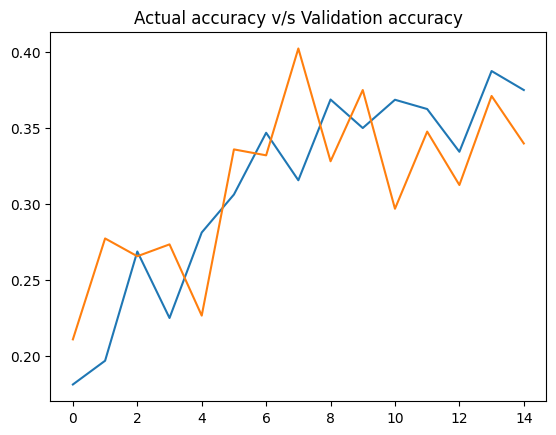

In [31]:
plt.plot(val["accuracy"])
plt.plot(val["val_accuracy"])
plt.title("Actual accuracy v/s Validation accuracy")
plt.show()

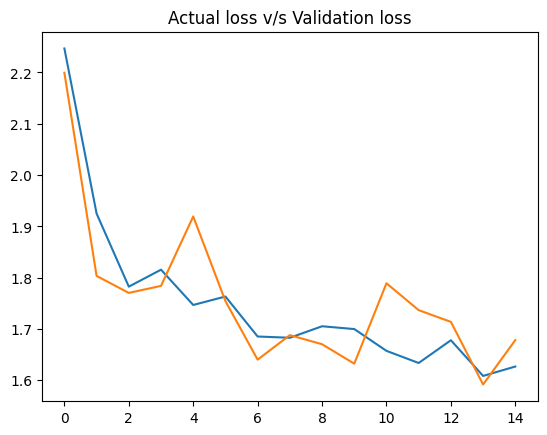

In [32]:
plt.plot(val["loss"])
plt.plot(val["val_loss"])
plt.title("Actual loss v/s Validation loss")
plt.show()

In [33]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_8
1 conv1
2 conv1_bn
3 conv1_relu
4 conv_dw_1
5 conv_dw_1_bn
6 conv_dw_1_relu
7 conv_pw_1
8 conv_pw_1_bn
9 conv_pw_1_relu
10 conv_pad_2
11 conv_dw_2
12 conv_dw_2_bn
13 conv_dw_2_relu
14 conv_pw_2
15 conv_pw_2_bn
16 conv_pw_2_relu
17 conv_dw_3
18 conv_dw_3_bn
19 conv_dw_3_relu
20 conv_pw_3
21 conv_pw_3_bn
22 conv_pw_3_relu
23 conv_pad_4
24 conv_dw_4
25 conv_dw_4_bn
26 conv_dw_4_relu
27 conv_pw_4
28 conv_pw_4_bn
29 conv_pw_4_relu
30 conv_dw_5
31 conv_dw_5_bn
32 conv_dw_5_relu
33 conv_pw_5
34 conv_pw_5_bn
35 conv_pw_5_relu
36 conv_pad_6
37 conv_dw_6
38 conv_dw_6_bn
39 conv_dw_6_relu
40 conv_pw_6
41 conv_pw_6_bn
42 conv_pw_6_relu
43 conv_dw_7
44 conv_dw_7_bn
45 conv_dw_7_relu
46 conv_pw_7
47 conv_pw_7_bn
48 conv_pw_7_relu
49 conv_dw_8
50 conv_dw_8_bn
51 conv_dw_8_relu
52 conv_pw_8
53 conv_pw_8_bn
54 conv_pw_8_relu
55 conv_dw_9
56 conv_dw_9_bn
57 conv_dw_9_relu
58 conv_pw_9
59 conv_pw_9_bn
60 conv_pw_9_relu
61 conv_dw_10
62 conv_dw_10_bn
63 conv_dw_10_relu
64 conv_pw_10
65 conv_pw_1

In [36]:
for layer in model.layers[:43]:
   layer.trainable = False
for layer in model.layers[43:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

In [39]:
early_stopping=EarlyStopping(monitor="val_accuracy",verbose=1,min_delta=0.01, mode="auto", patience=7)
model_checkpoint=ModelCheckpoint(filepath="best_model.h5", monitor="val_accuracy",verbose=1,save_best_only=True,mode="auto")
values=model.fit_generator(train_data,
                           epochs=30,
                           steps_per_epoch=10,
                           validation_data=val_data,
                           validation_steps=8,
                           callbacks=callbacks)

<ipython-input-39-c61d46a3f146>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  values=model.fit_generator(train_data,


Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 1.3728

10/10 [==============================] - 4s 415ms/step - loss: 1.3728 - val_loss: 1.4583
Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 1.3971

10/10 [==============================] - 4s 424ms/step - loss: 1.3971 - val_loss: 1.3330
Epoch 3/30
10/10 [==============================] - ETA: 0s - loss: 1.4548

10/10 [==============================] - 4s 424ms/step - loss: 1.4548 - val_loss: 1.3277
Epoch 4/30
10/10 [==============================] - ETA: 0s - loss: 1.3294

10/10 [==============================] - 4s 413ms/step - loss: 1.3294 - val_loss: 1.3777
Epoch 5/30
10/10 [==============================] - ETA: 0s - loss: 1.4384

10/10 [==============================] - 5s 544ms/step - loss: 1.4384 - val_loss: 1.4069
Epoch 6/30
10/10 [==============================] - ETA: 0s - loss: 1.4462

10/10 [==============================] - 5s 521ms/step - loss: 1.4462 - val_loss: 1.3146
Epoch 7/30
10/10 [==============================] - ETA: 0s - loss: 1.3698

10/10 [==============================] - 4s 423ms/step - loss: 1.3698 - val_loss: 1.3023
Epoch 8/30
10/10 [==============================] - ETA: 0s - loss: 1.4102

10/10 [==============================] - 5s 521ms/step - loss: 1.4102 - val_loss: 1.3383
Epoch 9/30
10/10 [==============================] - ETA: 0s - loss: 1.4068

10/10 [==============================] - 4s 433ms/step - loss: 1.4068 - val_loss: 1.4167
Epoch 10/30
10/10 [==============================] - ETA: 0s - loss: 1.4807

10/10 [==============================] - 5s 536ms/step - loss: 1.4807 - val_loss: 1.3700
Epoch 11/30
10/10 [==============================] - ETA: 0s - loss: 1.3638

10/10 [==============================] - 4s 430ms/step - loss: 1.3638 - val_loss: 1.3580
Epoch 12/30
10/10 [==============================] - ETA: 0s - loss: 1.5245

10/10 [==============================] - 4s 413ms/step - loss: 1.5245 - val_loss: 1.4114
Epoch 13/30
10/10 [==============================] - ETA: 0s - loss: 1.4412

10/10 [==============================] - 5s 529ms/step - loss: 1.4412 - val_loss: 1.3823
Epoch 14/30
10/10 [==============================] - ETA: 0s - loss: 1.4465

10/10 [==============================] - 4s 433ms/step - loss: 1.4465 - val_loss: 1.3826
Epoch 15/30
10/10 [==============================] - ETA: 0s - loss: 1.4040

10/10 [==============================] - 5s 536ms/step - loss: 1.4040 - val_loss: 1.3818
Epoch 16/30
10/10 [==============================] - ETA: 0s - loss: 1.4319

10/10 [==============================] - 5s 478ms/step - loss: 1.4319 - val_loss: 1.3548
Epoch 17/30
10/10 [==============================] - ETA: 0s - loss: 1.4865

10/10 [==============================] - 4s 428ms/step - loss: 1.4865 - val_loss: 1.3513
Epoch 18/30
10/10 [==============================] - ETA: 0s - loss: 1.3950

10/10 [==============================] - 6s 483ms/step - loss: 1.3950 - val_loss: 1.3234
Epoch 19/30
10/10 [==============================] - ETA: 0s - loss: 1.3900

10/10 [==============================] - 5s 556ms/step - loss: 1.3900 - val_loss: 1.3934
Epoch 20/30
10/10 [==============================] - ETA: 0s - loss: 1.4531

10/10 [==============================] - 4s 424ms/step - loss: 1.4531 - val_loss: 1.3782
Epoch 21/30
10/10 [==============================] - ETA: 0s - loss: 1.5565

10/10 [==============================] - 4s 423ms/step - loss: 1.5565 - val_loss: 1.3498
Epoch 22/30
10/10 [==============================] - ETA: 0s - loss: 1.3543

10/10 [==============================] - 5s 457ms/step - loss: 1.3543 - val_loss: 1.3914
Epoch 23/30
10/10 [==============================] - ETA: 0s - loss: 1.3886

10/10 [==============================] - 4s 435ms/step - loss: 1.3886 - val_loss: 1.3384
Epoch 24/30
10/10 [==============================] - ETA: 0s - loss: 1.4154

10/10 [==============================] - 5s 527ms/step - loss: 1.4154 - val_loss: 1.4105
Epoch 25/30
10/10 [==============================] - ETA: 0s - loss: 1.3536

10/10 [==============================] - 4s 410ms/step - loss: 1.3536 - val_loss: 1.2573
Epoch 26/30
10/10 [==============================] - ETA: 0s - loss: 1.4037

10/10 [==============================] - 4s 425ms/step - loss: 1.4037 - val_loss: 1.4474
Epoch 27/30
10/10 [==============================] - ETA: 0s - loss: 1.3670

10/10 [==============================] - 6s 593ms/step - loss: 1.3670 - val_loss: 1.3711
Epoch 28/30
10/10 [==============================] - ETA: 0s - loss: 1.4759

10/10 [==============================] - 4s 437ms/step - loss: 1.4759 - val_loss: 1.3166
Epoch 29/30
10/10 [==============================] - ETA: 0s - loss: 1.4584

10/10 [==============================] - 5s 539ms/step - loss: 1.4584 - val_loss: 1.3307
Epoch 30/30
10/10 [==============================] - ETA: 0s - loss: 1.4612

10/10 [==============================] - 4s 435ms/step - loss: 1.4612 - val_loss: 1.3036


In [40]:
model.save('model.h5')

In [45]:
val=values.history
val.keys()

dict_keys(['loss', 'val_loss'])

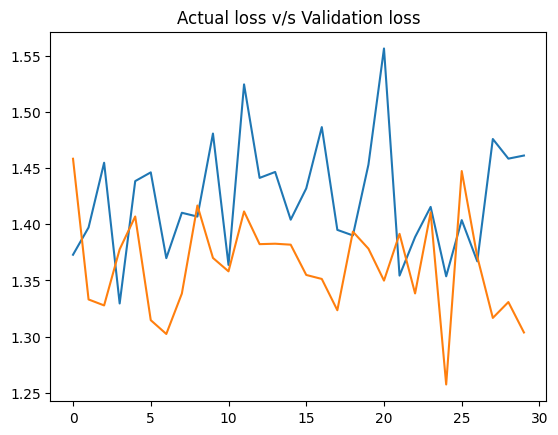

In [46]:
plt.plot(val["loss"])
plt.plot(val["val_loss"])
plt.title("Actual loss v/s Validation loss")
plt.show()

In [47]:
op = dict(zip( train_data.class_indices.values(), train_data.class_indices.keys()))
op

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

(1, 224, 224, 3)
1/1 [==============================] - 0s 30ms/step
 the image is of happy


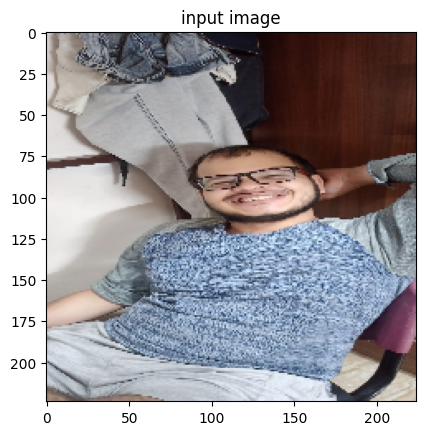

In [49]:
path = "/content/WhatsApp Image 2023-07-30 at 00.40.07.jpg"
img = load_img(path, target_size=(224,224) )

i = img_to_array(img)/255
input_arr = np.array([i])
print(input_arr.shape)

pred = np.argmax(model.predict(input_arr))

print(f" the image is of {op[pred]}")

# to display the image
plt.imshow(input_arr[0])
plt.title("input image")
plt.show()
